# Imports

In [24]:
import os
import sys
import itertools
from typing import List

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

sys.path.append("../../")
sys.path.append("../../source_code")

from source_code import (utils, analysis, feature_engineering, modelling)

print("Last Modified: ", utils.current_timestamp())

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Last Modified:  07-30-2021_08-46-01


In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# EDA

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7111 entries, 0 to 7110
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date_time               7111 non-null   object 
 1   deg_C                   7111 non-null   float64
 2   relative_humidity       7111 non-null   float64
 3   absolute_humidity       7111 non-null   float64
 4   sensor_1                7111 non-null   float64
 5   sensor_2                7111 non-null   float64
 6   sensor_3                7111 non-null   float64
 7   sensor_4                7111 non-null   float64
 8   sensor_5                7111 non-null   float64
 9   target_carbon_monoxide  7111 non-null   float64
 10  target_benzene          7111 non-null   float64
 11  target_nitrogen_oxides  7111 non-null   float64
dtypes: float64(11), object(1)
memory usage: 666.8+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_time          2247 non-null   object 
 1   deg_C              2247 non-null   float64
 2   relative_humidity  2247 non-null   float64
 3   absolute_humidity  2247 non-null   float64
 4   sensor_1           2247 non-null   float64
 5   sensor_2           2247 non-null   float64
 6   sensor_3           2247 non-null   float64
 7   sensor_4           2247 non-null   float64
 8   sensor_5           2247 non-null   float64
dtypes: float64(8), object(1)
memory usage: 158.1+ KB


In [5]:
train.head(2)

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.100,46.000,0.758,1387.200,1087.800,1056.000,1742.800,1293.400,2.500,12.000,167.700
1,2010-03-10 19:00:00,13.200,45.300,0.726,1279.100,888.200,1197.500,1449.900,1010.900,2.100,9.900,98.900


In [6]:
TARGET_COLUMNS =  [col for col in train.columns if 'target' in col]    
FEATURE_COLUMNS = [col for col in train.columns if col not in TARGET_COLUMNS]
ORIGINAL_NUM_FEATURE_COLUMNS = train[FEATURE_COLUMNS].select_dtypes(include=np.number).columns

# Feature Engineering

In [7]:
def feature_hourly_lag(df: pd.DataFrame, lag_features: List[str], lags: List[int]) -> pd.DataFrame:
    for feature, lag in itertools.product(lag_features, lags):
        df[feature + '_' + str(lag) + '_lag'] = df[feature] - df[feature].shift(periods=lag, fill_value=0)
    return df
        
def data_preprocessing(df) -> pd.DataFrame:
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['year'] = df['date_time'].dt.year
    df['month'] = df['date_time'].dt.month
    df['week'] = df['date_time'].dt.week
    df['day'] = df['date_time'].dt.day
    df['day_of_week'] = df['date_time'].dt.dayofweek
    df['hour'] = df['date_time'].dt.hour
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['working_hours'] = (df['hour'].isin(np.arange(7, 20))).astype(int)
    df['night_hours'] = (~(df['hour'].isin(np.arange(6, 22)))).astype(int)
    df['season'] = feature_engineering.get_season_from_date_time_feature(
        df['date_time'])
    # df.drop(['date_time'],axis=1, inplace=True)

    # SMC - Site mean concentration, calculation: (absolute_humid * 100)/(relative humidity)
    df['smc'] = (100 * df['absolute_humidity']) / df['relative_humidity']

    # Introduce Lags
    df = feature_hourly_lag(df, ['sensor_1','sensor_2','sensor_3','sensor_4','sensor_5','smc', 'absolute_humidity', 'deg_C'], [1,2,3,6,12,24])
    
    df.replace(to_replace=np.inf, value=0, inplace=True)
    return df

In [8]:
train = data_preprocessing(train)
test = data_preprocessing(test)

/home/jeris/src/kaggle-competitions/env/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


In [9]:
NUM_FEATURE_COLUMNS = train[FEATURE_COLUMNS].select_dtypes(include=np.number).columns

In [10]:
train.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,year,month,week,day,day_of_week,hour,is_weekend,working_hours,night_hours,season,smc,sensor_1_1_lag,sensor_1_2_lag,sensor_1_3_lag,sensor_1_6_lag,sensor_1_12_lag,sensor_1_24_lag,sensor_2_1_lag,sensor_2_2_lag,sensor_2_3_lag,sensor_2_6_lag,sensor_2_12_lag,sensor_2_24_lag,sensor_3_1_lag,sensor_3_2_lag,sensor_3_3_lag,sensor_3_6_lag,sensor_3_12_lag,sensor_3_24_lag,sensor_4_1_lag,sensor_4_2_lag,sensor_4_3_lag,sensor_4_6_lag,sensor_4_12_lag,sensor_4_24_lag,sensor_5_1_lag,sensor_5_2_lag,sensor_5_3_lag,sensor_5_6_lag,sensor_5_12_lag,sensor_5_24_lag,smc_1_lag,smc_2_lag,smc_3_lag,smc_6_lag,smc_12_lag,smc_24_lag,absolute_humidity_1_lag,absolute_humidity_2_lag,absolute_humidity_3_lag,absolute_humidity_6_lag,absolute_humidity_12_lag,absolute_humidity_24_lag,deg_C_1_lag,deg_C_2_lag,deg_C_3_lag,deg_C_6_lag,deg_C_12_lag,deg_C_24_lag
0,2010-03-10 18:00:00,13.100,46.000,0.758,1387.200,1087.800,1056.000,1742.800,1293.400,2.500,12.000,167.700,2010,3,10,10,2,18,0,1,0,2,1.647,1387.200,1387.200,1387.200,1387.200,1387.200,1387.200,1087.800,1087.800,1087.800,1087.800,1087.800,1087.800,1056.000,1056.000,1056.000,1056.000,1056.000,1056.000,1742.800,1742.800,1742.800,1742.800,1742.800,1742.800,1293.400,1293.400,1293.400,1293.400,1293.400,1293.400,1.647,1.647,1.647,1.647,1.647,1.647,0.758,0.758,0.758,0.758,0.758,0.758,13.100,13.100,13.100,13.100,13.100,13.100
1,2010-03-10 19:00:00,13.200,45.300,0.726,1279.100,888.200,1197.500,1449.900,1010.900,2.100,9.900,98.900,2010,3,10,10,2,19,0,1,0,2,1.602,-108.100,1279.100,1279.100,1279.100,1279.100,1279.100,-199.600,888.200,888.200,888.200,888.200,888.200,141.500,1197.500,1197.500,1197.500,1197.500,1197.500,-292.900,1449.900,1449.900,1449.900,1449.900,1449.900,-282.500,1010.900,1010.900,1010.900,1010.900,1010.900,-0.046,1.602,1.602,1.602,1.602,1.602,-0.032,0.726,0.726,0.726,0.726,0.726,0.100,13.200,13.200,13.200,13.200,13.200
2,2010-03-10 20:00:00,12.600,56.200,0.750,1331.900,929.600,1060.200,1586.100,1117.000,2.200,9.200,127.100,2010,3,10,10,2,20,0,0,0,2,1.335,52.800,-55.300,1331.900,1331.900,1331.900,1331.900,41.400,-158.200,929.600,929.600,929.600,929.600,-137.300,4.200,1060.200,1060.200,1060.200,1060.200,136.200,-156.700,1586.100,1586.100,1586.100,1586.100,106.100,-176.400,1117.000,1117.000,1117.000,1117.000,-0.267,-0.313,1.335,1.335,1.335,1.335,0.025,-0.008,0.750,0.750,0.750,0.750,-0.600,-0.500,12.600,12.600,12.600,12.600
3,2010-03-10 21:00:00,11.000,62.400,0.787,1321.000,929.000,1102.900,1536.500,1263.200,2.200,9.700,177.200,2010,3,10,10,2,21,0,0,0,2,1.261,-10.900,41.900,-66.200,1321.000,1321.000,1321.000,-0.600,40.800,-158.800,929.000,929.000,929.000,42.700,-94.600,46.900,1102.900,1102.900,1102.900,-49.600,86.600,-206.300,1536.500,1536.500,1536.500,146.200,252.300,-30.200,1263.200,1263.200,1263.200,-0.074,-0.341,-0.387,1.261,1.261,1.261,0.036,0.061,0.029,0.787,0.787,0.787,-1.600,-2.200,-2.100,11.000,11.000,11.000
4,2010-03-10 22:00:00,11.900,59.000,0.789,1272.000,852.700,1180.900,1415.500,1132.200,1.500,6.400,121.800,2010,3,10,10,2,22,0,0,1,2,1.337,-49.000,-59.900,-7.100,1272.000,1272.000,1272.000,-76.300,-76.900,-35.500,852.700,852.700,852.700,78.000,120.700,-16.600,1180.900,1180.900,1180.900,-121.000,-170.600,-34.400,1415.500,1415.500,1415.500,-131.000,15.200,121.300,1132.200,1132.200,1132.200,0.076,0.002,-0.265,1.337,1.337,1.337,0.002,0.039,0.063,0.789,0.789,0.789,0.900,-0.700,-1.300,11.900,11.900,11.900


In [11]:
train_df = train.copy()
test_df = test.copy()

## Skewed Target features transformation

<AxesSubplot:xlabel='target_nitrogen_oxides', ylabel='Density'>

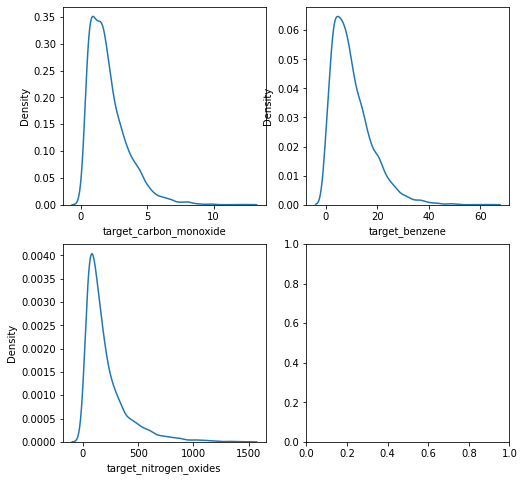

In [12]:
fig,axes = plt.subplots(2,2, figsize=(8,8))
sns.kdeplot(data=train[TARGET_COLUMNS[0]],ax=axes[0,0])
sns.kdeplot(data=train[TARGET_COLUMNS[1]],ax=axes[0,1])
sns.kdeplot(data=train[TARGET_COLUMNS[2]],ax=axes[1,0])

### Insight:

* skewed target features ... try log transformation

In [13]:
for feature in TARGET_COLUMNS:
    train_df[feature] = feature_engineering.log_scaling(train_df[feature])

<AxesSubplot:xlabel='target_nitrogen_oxides', ylabel='Density'>

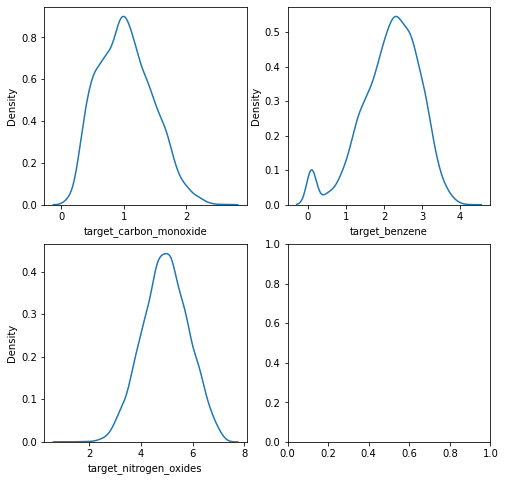

In [14]:
fig,axes = plt.subplots(2,2, figsize=(8,8))
sns.kdeplot(data=train_df[TARGET_COLUMNS[0]],ax=axes[0,0])
sns.kdeplot(data=train_df[TARGET_COLUMNS[1]],ax=axes[0,1])
sns.kdeplot(data=train_df[TARGET_COLUMNS[2]],ax=axes[1,0])

## Polynomial Features

In [15]:
def polynomial_features_fit_transform(df_train: pd.DataFrame, polynomial_args: dict) -> (pd.DataFrame, PolynomialFeatures):
    poly = PolynomialFeatures(**polynomial_args)
    poly.fit(df_train)
    return pd.DataFrame(poly.transform(df_train), index= df_train.index, columns=poly.get_feature_names(df_train.columns)), poly

In [16]:
def polynomial_features_transform(df_test: pd.DataFrame, polynomial_object) -> pd.DataFrame:
    return pd.DataFrame(polynomial_object.transform(df_test), index= df_test.index, columns=poly.get_feature_names(df_test.columns))

In [17]:
train_df_1 = train_df.copy()
test_df_1 = test_df.copy()

In [18]:
train_df_poly, poly = polynomial_features_fit_transform(train_df[NUM_FEATURE_COLUMNS], {'degree':2})
train_df_1 = train_df.drop(NUM_FEATURE_COLUMNS, axis=1)
train_df_1 = pd.concat([train_df_1,train_df_poly],axis=1)

test_df_poly = polynomial_features_transform(test_df[NUM_FEATURE_COLUMNS], poly)
test_df_1 = test_df.drop(NUM_FEATURE_COLUMNS, axis=1)
test_df_1 = pd.concat([test_df_1,test_df_poly],axis=1)

In [19]:
train_df = train_df_1.copy()
test_df = test_df_1.copy()

# Split Data

In [20]:
test_size = 0.33
test_idx = int(1-len(train)*test_size)

In [21]:
train_df_clean = train_df.drop(['date_time'], axis=1)
test_df_clean = test_df.drop(['date_time'], axis=1)

In [22]:
tr = train_df_clean.iloc[:test_idx]
te = train_df_clean.iloc[test_idx:]


X_train = tr.drop(TARGET_COLUMNS,axis=1)
y_train = tr[TARGET_COLUMNS[0]]

X_test = te.drop(TARGET_COLUMNS,axis=1)
y_test = tr[TARGET_COLUMNS[0]]

# Scale Numerical Data

In [29]:
num_features = X_train.select_dtypes(include=np.number).columns

In [33]:
scaler = MinMaxScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

# Base Model Comparison

In [35]:
experiments = modelling.run_experiments(X_train, X_test, y_train, y_test, False)

 60%|██████████████████████████▍                 | 6/10 [00:10<00:08,  2.11s/it]/home/jeris/src/kaggle-competitions/env/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/jeris/src/kaggle-competitions/env/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/jeris/src/kaggle-competitions/env/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/jeris/src/kaggle-competitions/env/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,fit_time,score_time,test_explained_variance,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,model
0,0.028,0.006,0.931,0.930,-0.075,-0.011,lr
1,0.096,0.009,0.925,0.925,-0.074,-0.011,lr
2,0.034,0.007,0.932,0.932,-0.074,-0.011,lr
3,0.032,0.006,0.934,0.934,-0.077,-0.010,lr
4,0.031,0.006,0.942,0.942,-0.070,-0.009,lr
5,0.017,0.007,0.000,-0.005,-0.320,-0.154,lasso
6,0.019,0.005,0.000,-0.001,-0.315,-0.150,lasso
7,0.016,0.005,0.000,-0.002,-0.328,-0.164,lasso
8,0.017,0.005,0.000,-0.006,-0.324,-0.159,lasso
9,0.016,0.005,0.000,-0.006,-0.328,-0.158,lasso


# PCA